# Bird Species Classification Using 3 seconds Spectrograms and ResNet50

This notebook trains a deep learning model to classify bird species based on spectrogram images of their vocalizations. Using a ResNet50 architecture pre-trained on ImageNet, we fine-tune the model on BIRDeep dataset of bird vocalizations. The trained model is used for inference, generating structured CSV outputs with predicted species for segmented test audio recordings.

## Libraries

In [458]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Metric, F1Score
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, f1_score

In [459]:
tf.config.set_visible_devices([], 'GPU')

# if tf.test.gpu_device_name(): # this lies and tells you about all devices
if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Constants and Hyperparameters

In [460]:
EXPERIMENT = "ResNet50DataAugmentation"

In [461]:
# Dataset Folders
TRAIN_FOLDER = "../../../Data/Dataset/images/For Classifier/train/"
VALIDATION_FOLDER = "../../../Data/Dataset/images/For Classifier/validation/"
TEST_FOLDER = "../../../Data/Dataset/images/For Classifier/test/"
BSD_TEST_FOLDER = "../../../Data/Dataset/images/For Classifier/BirdSongDetectorTestSegments/"

In [462]:
# check number of subfolders in train
print("Number of classes in Train folder: ", len(os.listdir(TRAIN_FOLDER)))

Number of classes in Train folder:  29


In [463]:
# Preprocesamiento
BATCH_SIZE = 16

TARGET_IMG_WIDTH = 224
TARGET_IMG_HEIGHT = 224
TARGET_IMG_CHANNELS = 3
TARGET_SIZE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT]
TARGET_SHAPE = [TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_CHANNELS]

NUM_CLASSES = len(os.listdir(TRAIN_FOLDER))

# metrics and checkpoint, macro metrics
CHECKPOINT_MONITOR = "val_accuracy"
CHECKPOINT_MODE = 'max'
METRICS = ["accuracy"]


EARLYSTOP_MONITOR = 'val_accuracy'
EARLYSTOP_MODE = 'val_accuracy'
EARLYSTOP_PATIENCE = 7

# LR_MONITOR = 'val_loss'
# LR_FACTOR = 0.5
# LR_PATIENCE = 5
# LR_MINLR = 0.0001

INITIAL_WEIGHTS = 'imagenet'

# Train
OPTIMIZER = "adam"
# LOSS = 'sparse_categorical_crossentropy'
LOSS = SparseCategoricalCrossentropy()

NUM_EPOCHS = 50

## Dataset visualization and preprocessing

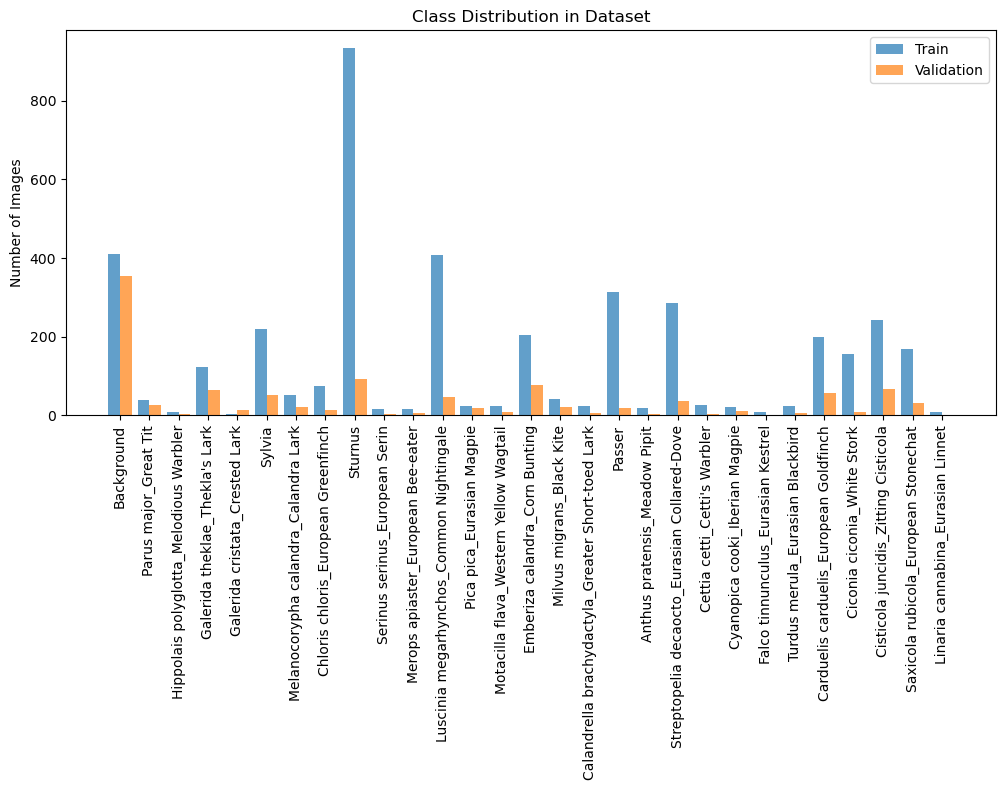

In [464]:
# Data visualization: Count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_per_class(TRAIN_FOLDER)
val_counts = count_images_per_class(VALIDATION_FOLDER)

# Plot class distribution without stacking bars
plt.figure(figsize=(12, 5))
width = 0.4  # the width of the bars
train_positions = np.arange(len(train_counts))
val_positions = train_positions + width

plt.bar(train_positions, train_counts.values(), width=width, color='C0', alpha=0.7, label='Train')
plt.bar(val_positions, val_counts.values(), width=width, color='C1', alpha=0.7, label='Validation')

plt.xticks(train_positions + width / 2, train_counts.keys(), rotation=90)
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.legend()
plt.show()

In [465]:
hsv_h= 0.015
hsv_s= 0.2
hsv_v= 0.2

def augment_image(img):
    img = tf.image.random_hue(img, hsv_h)
    img = tf.image.random_saturation(img, 1-hsv_s, 1+hsv_s)
    img = tf.image.random_brightness(img, hsv_v)
    return img

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=1.0,
    preprocessing_function=augment_image,
)

train_dataset = datagen.flow_from_directory(
    TRAIN_FOLDER,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_FOLDER, 
    batch_size=BATCH_SIZE, 
    image_size=TARGET_SIZE, 
    label_mode='int',
    shuffle=True,
)

Found 4080 images belonging to 29 classes.
Found 1061 files belonging to 29 classes.


In [466]:
# # image to augment, the same image is augmented 4 times
# image = next(iter(train_dataset.take(1)))[0][1]

# # take random image and apply maximum values of each augmentations, above each image, the augmentation and value
# hsv_s= 0.7
# hsv_v= 0.4

# plt.figure(figsize=(10, 10))

# ax = plt.subplot(1, 5, 1)
# plt.imshow(image.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Original")

# # Plot the augmented images
# # 1- width_shift_range = 1.0
# ax = plt.subplot(1, 5, 2)
# augmented = augment_image(image)
# plt.imshow(augmented.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Augmented image")

# # 2- hsv_h= 0.015
# ax = plt.subplot(1, 5, 3)
# # apply directly hue = 0.015
# augmented_hue = tf.image.adjust_hue(image, 0.015)
# plt.imshow(augmented_hue.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Hue = 0.015")

# # 3- hsv_s= 0.7
# ax = plt.subplot(1, 5, 4)
# augmented_saturation = tf.image.adjust_saturation(image, 1.3)
# plt.imshow(augmented_saturation.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Saturation = 0.7")

# # 4- hsv_v= 0.4
# ax = plt.subplot(1, 5, 5)
# augmented_bright = tf.image.adjust_brightness(image, 0.4)
# plt.imshow(augmented_bright.numpy().astype("uint8"))
# plt.axis("off")
# plt.title("Brightness = 0.4")

# plt.show()

## ResNet50 Model

### Load model

Pretrained with ImageNet weights and freeze all layers except the last one to do two training steps: first, train the last layers, and then train the whole model.

In [467]:
# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

In [468]:
# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [469]:
# Compile model
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)

In [470]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,119,709 (92.01 MB)

 Trainable params: 531,997 (2.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Callbacks configuration

In [471]:
model_save_path = f"../../models/DeepLearningModels/{EXPERIMENT}/"

# if model save path does not exist, create it
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

In [472]:
# Definir Early Stopping
early_stopping = EarlyStopping(
    monitor=EARLYSTOP_MONITOR,
    mode=EARLYSTOP_MODE,
    patience=EARLYSTOP_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

# callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_save_path + "best_model.keras",
    monitor=CHECKPOINT_MONITOR,
    mode=CHECKPOINT_MODE,
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

csv_logger = CSVLogger(
    model_save_path + "training_log.csv", 
    append=True
)


# Definir ReduceLROnPlateau
# Politicas de LR
# reduce_lr = ReduceLROnPlateau(
#     monitor=LR_MONITOR,
#     factor=LR_FACTOR,
#     patience=LR_PATIENCE,
#     # min_lr=LR_MINLR,
#     verbose = 1)
# monitor = mean_absolute_error



In [473]:
# Callbacks
CALLBACKS = [
    early_stopping,
    checkpoint,
    csv_logger
    # reduce_lr,
]

### Training

In [474]:
history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=CALLBACKS)

/home/gruncrow/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.2054 - loss: 2.7994
Epoch 1: val_accuracy improved from -inf to 0.12158, saving model to ../../models/DeepLearningModels/ResNet50DataAugmentation/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 189s 722ms/step - accuracy: 0.2054 - loss: 2.7990 - val_accuracy: 0.1216 - val_loss: 3.6108
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.2421 - loss: 2.5827
Epoch 2: val_accuracy improved from 0.12158 to 0.13384, saving model to ../../models/DeepLearningModels/ResNet50DataAugmentation/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 184s 723ms/step - accuracy: 0.2421 - loss: 2.5828 - val_accuracy: 0.1338 - val_loss: 4.5456
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.2362 - loss: 2.5582
Epoch 3: val_accuracy improved from 0.13384 to 0.15269, saving model to ../../models/DeepLearningModels/ResNet50DataAugmentation/best_model.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 190s 743ms/step - accuracy: 0.

### Validation evaluation

In [475]:
# Evaluate model with validation
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 534ms/step - accuracy: 0.3149 - loss: 31.9778
Validation Loss: 30.271303176879883, Validation Accuracy: 0.3402450382709503


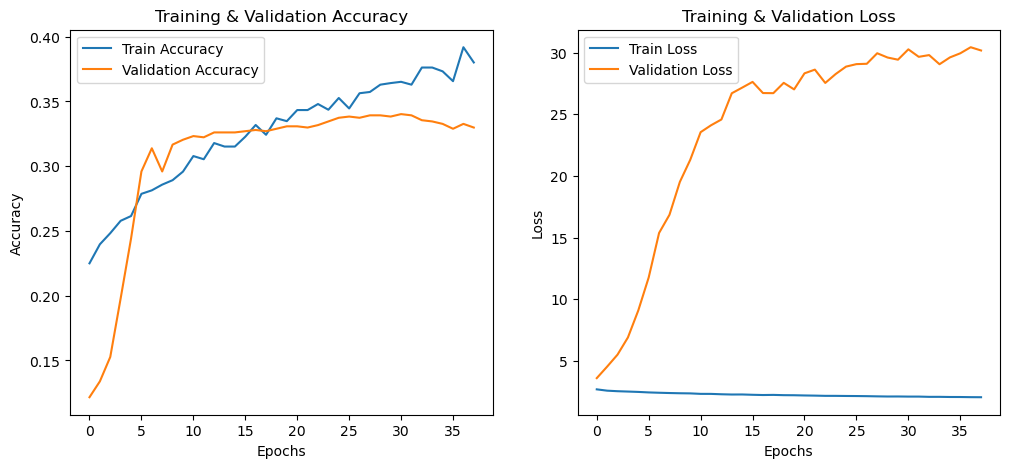

In [476]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [477]:
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = np.argmax(model.predict(val_dataset), axis=1)
print(classification_report(y_true, y_pred, target_names=val_dataset.class_names))

67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 566ms/step
                                                   precision    recall  f1-score   support

                    Anthus pratensis_Meadow Pipit       0.00      0.00      0.00         3
                                       Background       0.35      0.75      0.47       353
Calandrella brachydactyla_Greater Short-toed Lark       0.00      0.00      0.00         5
           Carduelis carduelis_European Goldfinch       0.00      0.00      0.00        57
                     Cettia cetti_Cetti's Warbler       0.00      0.00      0.00         3
              Chloris chloris_European Greenfinch       0.00      0.00      0.00        14
                      Ciconia ciconia_White Stork       0.00      0.00      0.00         9
             Cisticola juncidis_Zitting Cisticola       0.04      0.05      0.04        66
                   Cyanopica cooki_Iberian Magpie       0.00      0.00      0.00        11
                   Emberiza calandra_Corn Bunti

/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Re-training the model

In [478]:
# Make model trainable
model.trainable = True

In [479]:
# Train model
history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=CALLBACKS)

Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.3633 - loss: 2.1061
Epoch 1: val_accuracy did not improve from 0.34025
255/255 ━━━━━━━━━━━━━━━━━━━━ 191s 749ms/step - accuracy: 0.3633 - loss: 2.1061 - val_accuracy: 0.3393 - val_loss: 30.1700
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.3818 - loss: 2.0858
Epoch 2: val_accuracy did not improve from 0.34025
255/255 ━━━━━━━━━━━━━━━━━━━━ 191s 748ms/step - accuracy: 0.3817 - loss: 2.0858 - val_accuracy: 0.3355 - val_loss: 29.1374
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3795 - loss: 2.0917
Epoch 3: val_accuracy did not improve from 0.34025
255/255 ━━━━━━━━━━━━━━━━━━━━ 191s 747ms/step - accuracy: 0.3795 - loss: 2.0916 - val_accuracy: 0.3365 - val_loss: 29.4968
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.3751 - loss: 2.0358
Epoch 4: val_accuracy did not improve from 0.34025
255/255 ━━━━━━━━━━━━━━━━━━━━ 188s 737ms/step - accuracy: 0.3751 - loss: 2.0360

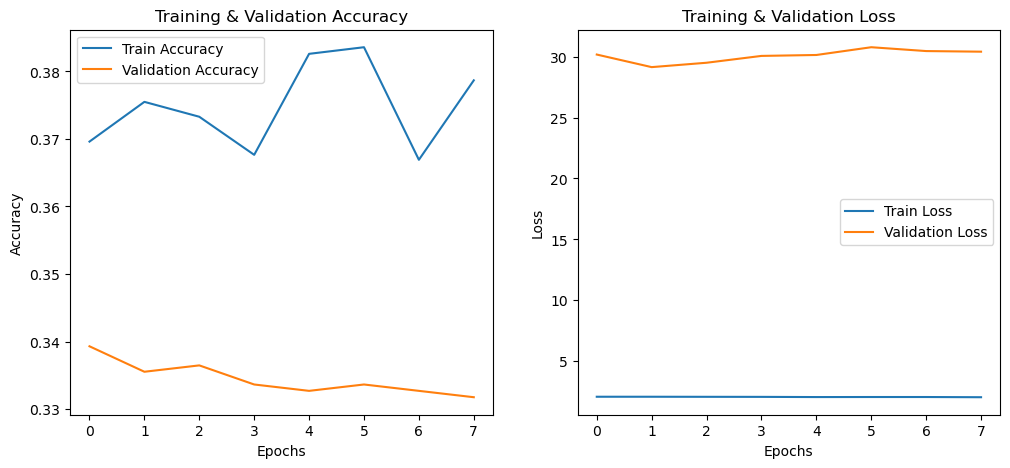

In [480]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [481]:
# Evaluate model with validation
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = np.argmax(model.predict(val_dataset), axis=1)
print(classification_report(y_true, y_pred, target_names=val_dataset.class_names))

67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 544ms/step - accuracy: 0.3341 - loss: 31.2222
Validation Loss: 30.169963836669922, Validation Accuracy: 0.33930253982543945
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 532ms/step
                                                   precision    recall  f1-score   support

                    Anthus pratensis_Meadow Pipit       0.00      0.00      0.00         3
                                       Background       0.33      0.70      0.45       353
Calandrella brachydactyla_Greater Short-toed Lark       0.00      0.00      0.00         5
           Carduelis carduelis_European Goldfinch       0.00      0.00      0.00        57
                     Cettia cetti_Cetti's Warbler       0.00      0.00      0.00         3
              Chloris chloris_European Greenfinch       0.00      0.00      0.00        14
                      Ciconia ciconia_White Stork       0.00      0.00      0.00         9
             Cisticola juncidis_Zitting Cisticola       0.06      0.05    

/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gruncrow/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Inference

In [ ]:
# # Inference

# def predict_and_save_results(test_folder, model):
#     for root, _, files in os.walk(test_folder):
#         predictions = []
#         for file in sorted(files):
#             if file.endswith(".PNG"):
#                 img_path = os.path.join(root, file)
#                 img = tf.keras.preprocessing.image.load_img(img_path, target_size=TARGET_SIZE)
#                 img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
#                 img_array = np.expand_dims(img_array, axis=0)
#                 pred = model.predict(img_array)
#                 class_idx = np.argmax(pred)
#                 class_name = list(train_counts.keys())[class_idx]
#                 confidence = np.max(pred)
                
#                 if class_name.lower() != "background":
#                     start_sec = int(file.split("_")[-1].split(".")[0]) * 3
#                     end_sec = start_sec + 3
#                     predictions.append([start_sec, end_sec, class_name.split('_')[0], class_name.split('_')[-1], confidence])
        
#         if predictions:
#             output_file = os.path.join(f"../Predictions/DeepLearning/{EXPERIMENT}", os.path.basename(root) + ".BirdNET.results.csv")
#             pd.DataFrame(predictions, columns=["Start (s)", "End (s)", "Scientific name", "Common name", "Confidence"]).to_csv(output_file, index=False)

# predict_and_save_results(TEST_FOLDER, model)